# The `QuantumState` class

Express an N-qubit quantum state as an array of N columns, where rows are binary bit values, complemented by a vector of coefficients. Note the similarity with the symplectic representation - indeed, the QuantumState class will infact set the above array as the X block in a PauliwordOp, with the Z block its complement.

What we are doing here is writing $|0\rangle = Z|0\rangle$ and $|1\rangle = X|0\rangle$, which ensures correct phases when multiplying the state by Pauli operators, since

$$X|0\rangle = XZ|0\rangle = -iY|0\rangle = |1\rangle,\; X|1\rangle = XX|0\rangle = |0\rangle$$
$$Y|0\rangle = YZ|0\rangle = iX|0\rangle = i|1\rangle,\; Y|1\rangle = YX|0\rangle = -iZ|0\rangle = -i|0\rangle$$
$$Z|0\rangle = ZZ|0\rangle = |0\rangle,\; Z|1\rangle = ZX|0\rangle = iY|0\rangle = -|1\rangle$$

Finally, we have $$| \vec{b} \rangle = \bigotimes_{i=1}^N \big(b_i X + (1-b_i) Z\big) | \vec{0} \rangle$$ and we may drop the zero vector and use the functionality of PauliwordOp to manipulate quantum states. In this represenation, a quantum state is stored as an operator consisting of Paulis $X, Z$, which is implicitly applied to the zero (or vacuum) state. 

In [1]:
import numpy as np
from symmer.symplectic import PauliwordOp, QuantumState

Firstly, note the correct phases under multiplication by a Pauli Y:

In [2]:
zero = QuantumState([[0]])
one = QuantumState([[1]])
Y = PauliwordOp.from_list(['Y'], [1])

print(f'{zero} -> {Y * zero}')
print(f'{one} -> {Y * one}')

 1.000+0.000j |0> ->  0.000+1.000j |1>
 1.000+0.000j |1> ->  0.000-1.000j |0>


Now, let's see what happens when we apply the Hadamard gate to the zero state:

In [3]:
from symmer.evolution import Had
psi = QuantumState([[0,0]])
H = Had(1, 0)
HH = H.tensor(H)
eq_superposition = HH * psi
print(f'Zero state: {psi}\n')
print(f'After application of a Hadamard gate on each qubit position:\n\n{eq_superposition}')

Zero state:  1.000+0.000j |00>

After application of a Hadamard gate on each qubit position:

 0.500+0.000j |00> +
 0.500+0.000j |01> +
 0.500+0.000j |10> +
 0.500-0.000j |11>


Observe that the QuantumState is represented internally by its `state_op`, a PauliwordOp object that governs its behaviour under multiplication

In [4]:
print(eq_superposition.state_op)

 0.500+0.000j ZZ +
 0.500+0.000j ZX +
 0.500+0.000j XZ +
 0.500-0.000j XX


Try evaluating expectation values for randomly generated states and Hermitian operators:

In [5]:
N = 5 # number of qubits
M = 10 # number of terms

psi_1 = QuantumState.random_state(N, M)
psi_2 = QuantumState.random_state(N, M)

print(psi_1)
print()
print(psi_2)

 0.124+0.223j |10001> +
 0.006+0.125j |10011> +
 0.315+0.312j |10011> +
 0.221+0.129j |00110> +
 0.258+0.066j |00111> +
 0.286+0.256j |00000> +
 0.271+0.158j |10010> +
 0.052+0.295j |01100> +
 0.259+0.262j |01100> +
 0.163+0.297j |11100>

 0.291+0.384j |11010> +
 0.044+0.283j |01111> +
 0.266+0.058j |10010> +
 0.148+0.161j |00110> +
 0.004+0.005j |10011> +
 0.403+0.160j |00010> +
 0.320+0.003j |01010> +
 0.274+0.118j |01100> +
 0.003+0.318j |00110> +
 0.068+0.281j |11001>


In [6]:
psi = (psi_1 + psi_2).normalize
print(psi)
print()
print('Norm:', psi.dagger * psi)

 0.165+0.147j |00000> +
 0.231+0.092j |00010> +
 0.214+0.349j |00110> +
 0.148+0.038j |00111> +
 0.184+0.002j |01010> +
 0.336+0.388j |01100> +
 0.025+0.162j |01111> +
 0.071+0.128j |10001> +
 0.308+0.124j |10010> +
 0.187+0.254j |10011> +
 0.039+0.162j |11001> +
 0.167+0.221j |11010> +
 0.094+0.171j |11100>

Norm: (1.0000000000000002+0j)


We may also generate haar-random states, although this is more computationally expensive due to an internal QR-decomposition.

In [7]:
psi = QuantumState.haar_random(N)
print(psi)

-0.092+0.009j |00000> +
-0.238-0.090j |00001> +
-0.013+0.045j |00010> +
-0.039-0.056j |00011> +
 0.051+0.062j |00100> +
 0.059+0.126j |00101> +
-0.096-0.033j |00110> +
-0.183+0.165j |00111> +
-0.155+0.071j |01000> +
-0.128-0.042j |01001> +
-0.274+0.025j |01010> +
 0.042-0.131j |01011> +
 0.109+0.229j |01100> +
-0.088-0.013j |01101> +
 0.014+0.205j |01110> +
-0.017+0.063j |01111> +
 0.238-0.143j |10000> +
 0.066-0.123j |10001> +
 0.003+0.048j |10010> +
 0.051+0.119j |10011> +
 0.204-0.251j |10100> +
 0.037+0.079j |10101> +
 0.027-0.125j |10110> +
-0.087-0.188j |10111> +
-0.027-0.182j |11000> +
-0.074-0.136j |11001> +
-0.085+0.222j |11010> +
 0.041+0.061j |11011> +
 0.115-0.144j |11100> +
 0.202+0.114j |11101> +
-0.059+0.001j |11110> +
-0.196-0.160j |11111>


In [8]:
print('Generate a random Hermitian operator:\n')
op = PauliwordOp.random(N, 10, complex_coeffs=False)
print(op)
print()
print('Expectation value <psi|op|psi> =', (psi.dagger * op * psi).real)

Generate a random Hermitian operator:

-0.628+0.000j YIIYX +
-0.476+0.000j ZYZIX +
 0.283+0.000j ZXIIY +
-0.340+0.000j IYXIX +
 0.150+0.000j IZXZY +
 0.638+0.000j ZXYIY +
-1.085+0.000j IIXIZ +
-1.319+0.000j YYIYY +
-0.957+0.000j YYIZI +
 0.731+0.000j IXIIX

Expectation value <psi|op|psi> = -0.43995664430038856


It is also possible to convert from a $2^N$ dimensional statevector over $N$ qubits to a `QuantumState` object, via the `from_array` initialization method:

In [9]:
statevector = np.zeros(2**10).reshape([-1,1])
statevector[0]   = np.sqrt(1/6)
statevector[250] = np.sqrt(2/6)
statevector[500] = np.sqrt(3/6)
psi = QuantumState.from_array(statevector)
print(psi)
print(psi.dagger * psi)

 0.408+0.000j |0000000000> +
 0.577+0.000j |0011111010> +
 0.707+0.000j |0111110100>
(1+0j)


# Manipulating Quantum Measurement Data

Given a dictionary of measurement outcomes from a quantum experiment, we may intialize a QuantumState for further postprocessing.

- Dictionary given as: 
    - key=bitstring
    - value=number of occurences or relative frequency

In [10]:
measurement_data = {
    '0101':4,
    '1101':10,
    '0001':20,
    '1111':16
}

psi_measured = QuantumState.from_dictionary(measurement_data)
psi_measured

 4.000+0.000j |0101> +
 10.000+0.000j |1101> +
 20.000+0.000j |0001> +
 16.000+0.000j |1111>

The coefficients here are the number of occurences of each output bitstring. These may be normalized using `normalize_counts` to ensure the correct probability distrubution is preserved:

 0.283+0.000j |0101> +
 0.447+0.000j |1101> +
 0.632+0.000j |0001> +
 0.566+0.000j |1111>


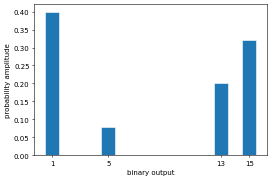

In [11]:
print(psi_measured.normalize_counts)
ax = psi_measured.normalize_counts.plot_state(dpi=50)

This is __not__ the same as taking the $L^2$-norm - the probability distrubtions do not align.

 0.144+0.000j |0101> +
 0.360+0.000j |1101> +
 0.720+0.000j |0001> +
 0.576+0.000j |1111>


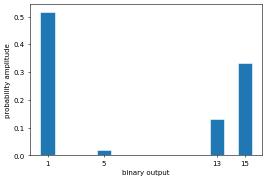

In [12]:
print(psi_measured.normalize)
# this shouldn't be used for normalizing quantum experiment data
# ... but functionality is still useful for normalizing states in the general setting
ax = psi_measured.normalize.plot_state(dpi=50)

# State sampling

It is also possible to randomly sample the state, just like a quantum experiment - this is particularly useful for the purposes of bootstrapping for statistical analysis of quantum experiments.

In [13]:
psi_measured_normalized = psi_measured.normalize_counts
psi_measured_normalized.sample_state(n_samples=50, return_normalized=True)

 0.316+0.000j |0101> +
 0.400+0.000j |1101> +
 0.663+0.000j |0001> +
 0.548+0.000j |1111>

Given enough samples, the original state will be reproduced exactly:

In [14]:
for n_samples in 2**np.arange(0, 30, 2):
    psi_sampled = psi_measured_normalized.sample_state(n_samples=n_samples, return_normalized=True)
    print(f'With n_samples={n_samples: <10}, <psi_sampled|psi_true> = {psi_sampled.dagger * psi_measured_normalized}')

With n_samples=1         , <psi_sampled|psi_true> = (0.565685424949238+0j)
With n_samples=4         , <psi_sampled|psi_true> = (0.8305652699797851+0j)
With n_samples=16        , <psi_sampled|psi_true> = (0.9954902016102906+0j)
With n_samples=64        , <psi_sampled|psi_true> = (0.999725792960293+0j)
With n_samples=256       , <psi_sampled|psi_true> = (0.9994644577520957+0j)
With n_samples=1024      , <psi_sampled|psi_true> = (0.9995985782825667+0j)
With n_samples=4096      , <psi_sampled|psi_true> = (0.9999262348753617+0j)
With n_samples=16384     , <psi_sampled|psi_true> = (0.9999985895805814+0j)
With n_samples=65536     , <psi_sampled|psi_true> = (0.9999996723422171+0j)
With n_samples=262144    , <psi_sampled|psi_true> = (0.9999993828875069+0j)
With n_samples=1048576   , <psi_sampled|psi_true> = (0.9999997925879097+0j)
With n_samples=4194304   , <psi_sampled|psi_true> = (0.9999998231976286+0j)
With n_samples=16777216  , <psi_sampled|psi_true> = (0.9999999802117033+0j)
With n_samples

# Plotting probabillity amplitudes of quantum state

In [15]:
%matplotlib inline
random_state = QuantumState.haar_random(3, vec_type='ket')
print(random_state)

 0.239-0.109j |000> +
-0.490-0.447j |001> +
-0.426-0.047j |010> +
-0.212+0.205j |011> +
-0.119+0.137j |100> +
 0.292-0.178j |101> +
-0.125-0.057j |110> +
-0.114-0.196j |111>


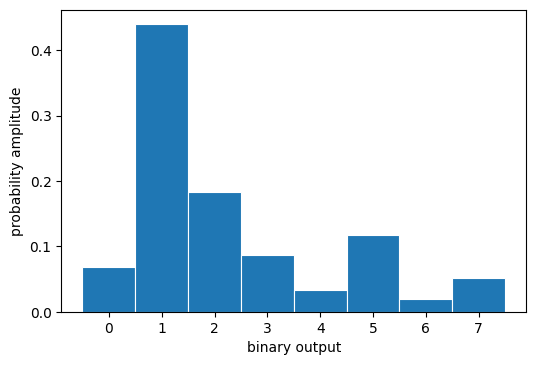

In [16]:
ax = random_state.plot_state(dpi=100)

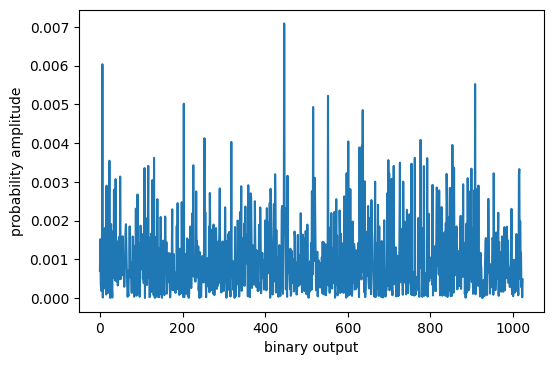

In [17]:
%matplotlib inline
random_large_state = QuantumState.haar_random(10, vec_type='ket')
ax2 = random_large_state.plot_state(logscale=False)

<AxesSubplot:xlabel='binary output', ylabel='probability amplitude'>

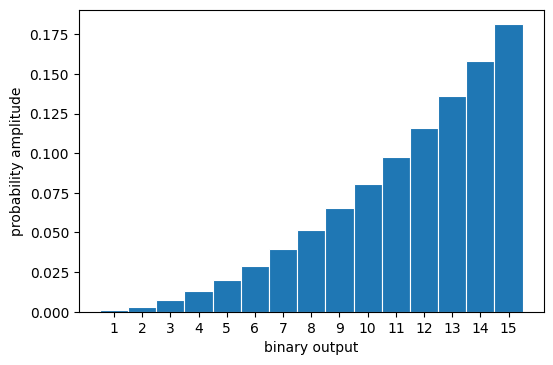

In [18]:
a = np.arange(2**4)
a = a/np.linalg.norm(a)
psi = QuantumState.from_array(a.reshape([-1,1]))
psi.plot_state()

<AxesSubplot:xlabel='binary output', ylabel='probability amplitude'>

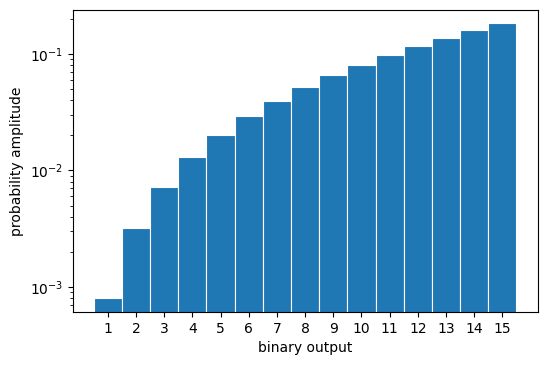

In [19]:
psi.plot_state(logscale=True)

<AxesSubplot:xlabel='binary output', ylabel='probability amplitude'>

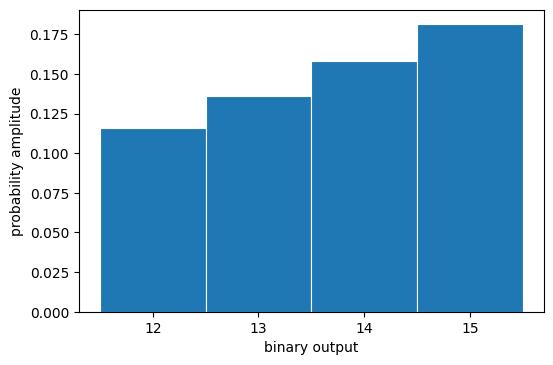

In [20]:
psi.plot_state(probability_threshold=0.1)